In [ ]:
import os
import random
import numpy as np
from keras.utils import to_categorical
import tensorflow as tf


from tensorflow.keras.optimizers import Adam
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalMaxPooling2D, BatchNormalization
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint # Ранний останов обучения, если точность валидации падает

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import itertools

In [ ]:

class Preprocess:
    def __init__(self, num_samples_per_class=700, batch_size=64):
        path_windows = "/kaggle/input/simpons/train/simpsons_dataset"

        self.num_labels = 42

        self.path_train = path_windows
        self.num_samples_per_class = num_samples_per_class
        self.batch_size = batch_size

        # Загружаем классы и создаем словарь
        self.dict_classes = {'rainier_wolfcastle': 45, 'maggie_simpson': 128, 'krusty_the_clown': 1206, 'waylon_smithers': 181, 'professor_john_frink': 65, 'fat_tony': 27, 'ralph_wiggum': 89, 'otto_mann': 32, 'martin_prince': 71, 'barney_gumble': 106, 'ned_flanders': 1454, 'patty_bouvier': 72, 'sideshow_mel': 40, 'marge_simpson': 1291, 'abraham_grampa_simpson': 913, 'selma_bouvier': 103, 'mayor_quimby': 246, 'disco_stu': 8, 'lionel_hutz': 3, 'troy_mcclure': 8, 'agnes_skinner': 42, 'groundskeeper_willie': 121, 'kent_brockman': 498, 'charles_montgomery_burns': 1193, 'carl_carlson': 98, 'chief_wiggum': 986, 'apu_nahasapeemapetilon': 623, 'bart_simpson': 1342, 'edna_krabappel': 457, 'gil': 27, 'comic_book_guy': 469, 'principal_skinner': 1194, 'cletus_spuckler': 47, 'milhouse_van_houten': 1079, 'snake_jailbird': 55, 'nelson_muntz': 358, 'lisa_simpson': 1354, 'lenny_leonard': 310, 'moe_szyslak': 1452, 'miss_hoover': 17, 'homer_simpson': 2246, 'sideshow_bob': 877}
        self.class_to_index = {label: idx for idx, label in enumerate(self.dict_classes.keys())}

        # Загружаем пути к изображениям и метки
        self.image_paths, self.labels = self.load_image_paths_and_labels()



    def load_image_paths_and_labels(self):
        """Загружает пути изображений и соответствующие метки"""
        image_paths = []
        labels = []
        count = 0
        for label, count in dict(itertools.islice(self.dict_classes.items(), self.num_labels)).items():
            class_dir = os.path.join(self.path_train, label)
            all_images = os.listdir(class_dir)
            
            # Берем нужное количество изображений
            selected_images = (
                random.choices(all_images, k=self.num_samples_per_class)
                if count < self.num_samples_per_class else all_images[:self.num_samples_per_class]
            )
    
            for img_name in selected_images:
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(self.class_to_index[label])
    

        return image_paths, labels

    def process_image(self, image_path, label, target_size=(224, 224), augment=True):
        # Обработка изображений, аугментация
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, target_size)

        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
            image = tf.image.random_hue(image, max_delta=0.02)
            image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
 
        image = image / 255.0  # Нормализация
        return image, label

    def create_dataset(self, shuffle=True):
        # Разбиваем датасет на обучающую выборку и выборку валидации
        train_img_split, val_img_split, train_lbl_split, val_lbl_split = train_test_split(
            self.image_paths, self.labels, random_state=1, test_size=0.2
        )
        train_lbl_split = to_categorical(train_lbl_split, num_classes=self.num_labels)
        val_lbl_split = to_categorical(val_lbl_split, num_classes=self.num_labels)

        
        # Создаем tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_img_split, train_lbl_split))
        train_dataset = train_dataset.map(lambda path, lbl: self.process_image(path, lbl),
                                          num_parallel_calls=tf.data.AUTOTUNE)

        val_dataset = tf.data.Dataset.from_tensor_slices((val_img_split, val_lbl_split))
        val_dataset = val_dataset.map(lambda path, lbl: self.process_image(path, lbl),
                                      num_parallel_calls=tf.data.AUTOTUNE)

        # Перемешивание
        if shuffle:
            train_dataset = train_dataset.shuffle(buffer_size=len(train_img_split))

        # Батчинг и предзагрузка в память
        train_dataset = train_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        val_dataset = val_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        return train_dataset, val_dataset


    def create_only_train(self, shuffle=True):
        
        train_lbl_split = to_categorical(self.labels, num_classes=self.num_labels)
   
        # Создаем tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((self.image_paths, train_lbl_split))
        train_dataset = train_dataset.map(lambda path, lbl: self.process_image(path, lbl),
                                          num_parallel_calls=tf.data.AUTOTUNE)

        # Перемешивание
        if shuffle:
            train_dataset = train_dataset.shuffle(buffer_size=len(self.image_paths))

        # Батчинг и предзагрузка в память
        train_dataset = train_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        return train_dataset





2.17.1


In [ ]:

pr = Preprocess()

class ModelResNet:
    def __init__(self):
        self.img_height, self.img_width = 224, 224
        self.batch_size = 20


    def build_model(self):
        # Создание модели
        model = Sequential([
            # Сверточные слои
            Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(self.img_height, self.img_width, 3)),
            MaxPooling2D(pool_size=(2, 2)),
            # BatchNormalization(),
            Dropout(rate=0.2),

            Conv2D(64, (3, 3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            # BatchNormalization(),
            Dropout(rate=0.2),


            Conv2D(128, (3, 3), padding='same', activation='relu'),
            # BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(256, (3, 3), padding='same', activation='relu'),
            # MaxPooling2D(pool_size=(2, 2)),
            
            # Conv2D(512, (3, 3), padding='same', activation='relu'),

            GlobalMaxPooling2D(), # Переход от 43, 43, 256 к 256
            # Выходной слой
            Dense(pr.num_labels, activation='softmax')
        ])

        print(model.compute_output_shape(input_shape=(None, self.img_height, self.img_width, 3)))

        # Компиляция модели
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model.summary()

        return model


In [ ]:


m = ModelResNet()
model = m.build_model()

class RAM:

    def train_model(self, train_dataset, val_dataset):


        # Определяем чекпоинты
        with tf.device('/GPU:0'):
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            checkpoint = ModelCheckpoint(
                f'keras_models/best_city_simpsons_1200_img.h5',  # Имя файла для сохранения
                monitor='val_loss',
                save_best_only=True,
                mode='min',
                verbose=1
            )
            # Обучаем модель с использованием чекпоинтов
            history = model.fit(
                train_dataset,
                epochs=15,
                validation_data=val_dataset,
                callbacks=[early_stopping, checkpoint]
            )

        hist = history.history
        x_arr = np.arange(len(hist['loss']))+1

        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2 ,1)
        ax.plot(x_arr, hist['loss'], '-o', label = 'Потеря при обучении')
        ax.plot(x_arr, hist['val_loss'], '--<', label='Потеря при проверке')
        ax.legend(fontsize = 15)
        ax.set_xlabel('Эпоха', size = 15)
        ax.set_ylabel('Потеря', size=15)
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label='Правильность при обучении')
        ax.plot(x_arr, hist['val_accuracy'], '--<', label='Правильность при проверке')
        ax.legend(fontsize=15)
        ax.set_xlabel('Эпоха', size=15)
        ax.set_ylabel('Правильность', size=15)

        plt.savefig('training_plot.png')




(None, 42)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 6

Num GPUs Available:  1
Создание датасета закончено
Epoch 1/15
368/368 [==============================] - ETA: 0s - loss: 2.8859 - accuracy: 0.2506
Epoch 1: val_loss improved from inf to 1.59784, saving model to keras_models/best_city_simpsons_1200_img.h5
368/368 [==============================] - 102s 124ms/step - loss: 2.8859 - accuracy: 0.2506 - val_loss: 1.5978 - val_accuracy: 0.5830
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


367/368 [============================>.] - ETA: 0s - loss: 1.0928 - accuracy: 0.7148
Epoch 2: val_loss improved from 1.59784 to 0.75999, saving model to keras_models/best_city_simpsons_1200_img.h5
368/368 [==============================] - 71s 113ms/step - loss: 1.0929 - accuracy: 0.7148 - val_loss: 0.7600 - val_accuracy: 0.8049
Epoch 3/15
367/368 [============================>.] - ETA: 0s - loss: 0.6086 - accuracy: 0.8374
Epoch 3: val_loss improved from 0.75999 to 0.59344, saving model to keras_models/best_city_simpsons_1200_img.h5
368/368 [==============================] - 72s 113ms/step - loss: 0.6082 - accuracy: 0.8374 - val_loss: 0.5934 - val_accuracy: 0.8412
Epoch 4/15
367/368 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8846
Epoch 4: val_loss improved from 0.59344 to 0.44919, saving model to keras_models/best_city_simpsons_1200_img.h5
368/368 [==============================] - 75s 114ms/step - loss: 0.4330 - accuracy: 0.8847 - val_loss: 0.4492 - val_ac

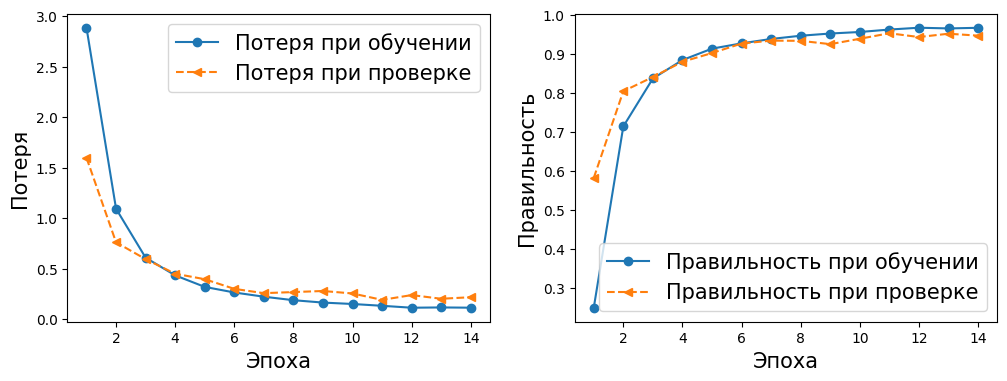

In [ ]:


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

prepro = Preprocess()
train_dataset, val_dataset = prepro.create_dataset()

print("Создание датасета закончено")
# prepro.cv2_view()
#
train = RAM()
train.train_model(train_dataset, val_dataset)


In [ ]:

from tensorflow.keras.models import load_model
import csv
import keras

print(keras.__version__)
print(tf.__version__)
# Подготовленный словарь для преобразования argmax в текстовую метку
rename_classes = {0: 'rainier_wolfcastle', 1: 'maggie_simpson', 2: 'krusty_the_clown', 3: 'waylon_smithers', 4: 'professor_john_frink', 5: 'fat_tony', 6: 'ralph_wiggum', 7: 'otto_mann', 8: 'martin_prince', 9: 'barney_gumble', 10: 'ned_flanders', 11: 'patty_bouvier', 12: 'sideshow_mel', 13: 'marge_simpson', 14: 'abraham_grampa_simpson', 15: 'selma_bouvier', 16: 'mayor_quimby', 17: 'disco_stu', 18: 'lionel_hutz', 19: 'troy_mcclure', 20: 'agnes_skinner', 21: 'groundskeeper_willie', 22: 'kent_brockman', 23: 'charles_montgomery_burns', 24: 'carl_carlson', 25: 'chief_wiggum', 26: 'apu_nahasapeemapetilon', 27: 'bart_simpson', 28: 'edna_krabappel', 29: 'gil', 30: 'comic_book_guy', 31: 'principal_skinner', 32: 'cletus_spuckler', 33: 'milhouse_van_houten', 34: 'snake_jailbird', 35: 'nelson_muntz', 36: 'lisa_simpson', 37: 'lenny_leonard', 38: 'moe_szyslak', 39: 'miss_hoover', 40: 'homer_simpson', 41: 'sideshow_bob'}

path = "/kaggle/input/simpons/testset/testset"
name_list = [name for name in os.listdir(path)]

model = load_model("/kaggle/working/keras_models/best_city_simpsons_700_img.h5")
def preprocess_image(image_path, target_height, target_width):
    # Загрузка изображения
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)

    resized_img = tf.image.resize(img, [target_height, target_width])  # Масштабирование изображений
    resized_img = resized_img / 255.0  # Нормализуем изображение

    return resized_img

images = []
names = []
# Формируем массив тестовых изображений
for img in name_list:
    full_path = f'{path}/{img}'
    processed_image = preprocess_image(full_path, 224, 224)
    images.append(processed_image)
    names.append(img)

images = np.array(images, dtype=np.float32)
print(f"Processed {len(images)} images")

# Предсказываем класс изображений
predictions = model.predict(images)

csv_dict = {}
for name, prediction in zip(names, predictions):
    class_ = np.argmax(prediction)
    label = rename_classes[class_]
    csv_dict[name] = label

# Загружаем в итоговый csv
with open('result_test_700.csv', mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Id", "Expected"])
    for key, value in csv_dict.items():
        writer.writerow([key, value])

3.5.0
2.17.1
Processed 991 images
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
